<a href="https://colab.research.google.com/github/wukongk/Data_Processing/blob/main/DPP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finance-datareader
!pip install scikit-learn
!pip install xgboost
!pip install matplotlib
!pip install pykrx
!pip install dart-fss
!pip install yfinance
!pip install mplfinance
!pip install OpenDartReader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 2.5.0
    Uninstalling termcolor-2.5.0:
      Successfully uninstalled termcolor-2.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
import FinanceDataReader as fdr
import yfinance as yf
import pandas as pd
import numpy as np
import OpenDartReader
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import os
import json
import joblib
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# JSON 파일 불러오기
file_path = '/content/drive/MyDrive/stock_predictions.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# 조건에 맞는 데이터 필터링
filtered_symbols = [
    pred['symbol']
    for pred in data['predictions']
    if (
        # ROE, ROA, DY가 모두 존재하는지 확인
        all(pred['indicators'].get(key, 0) != 0 for key in ['ROE', 'ROA', 'DY'])
    )
]

print(f"선별된 종목 수: {len(filtered_symbols)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
선별된 종목 수: 628


In [ ]:
class EnhancedStockPredictor:
    def __init__(self, symbols, company_names, start_date='2018-01-01', end_date=None):
        if len(symbols) != len(company_names):
            raise ValueError("학습 종목과 기업 이름 길이 불일치")
        self.symbols = symbols
        self.company_names = company_names
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
        self.models = {}
        self.features = ['Open', 'High', 'Low', 'Volume']
        self.additional_features = ['PER', 'ROA', 'ROE', 'DY', 'PBR', 'EPS', 'BPS',
                                  'Debt_Ratio', 'Current_Ratio', 'Operating_Margin', 'Net_Margin']
        self.rmse_scores = {}
        self.mape_scores = {}
        self.accuracy_scores = {'train': 0, 'test': 0}
        self.model_dir = '/content/drive/MyDrive/stock_models'
        os.makedirs(self.model_dir, exist_ok=True)

        # DART API 직접 초기화
        self.dart = OpenDartReader('01c3844f5c19edad942e3e0eaabd6626d2ffab9f')  # 여기에 실제 API 키 입력

        self.current_year = datetime.now().year
        self.current_quarter = (datetime.now().month - 1) // 3 + 1

    def fetch_financial_indicators(self, ticker):
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            return {
                'PER': float(info.get('trailingPegRatio', 0) or 0),  # None이나 빈 값을 0으로 처리
                'ROA': float(info.get('returnOnAssets', 0) or 0),
                'ROE': float(info.get('returnOnEquity', 0) or 0),
                'DY': float(info.get('dividendYield', 0) or 0)
            }
        except Exception as e:
            print(f"{ticker} 지표 가져오기 오류: {e}")
            return {key: 0.0 for key in self.additional_features}

    def prepare_data(self):
        all_features = []
        all_targets = []
        all_symbols = []
        all_directions = []
        all_current_prices = []

        for symbol in self.symbols:
            if symbol not in filtered_symbols:
                continue  # 필터링된 심볼에 없으면 건너뛰기

            try:
                print(f"{symbol} 데이터 다운로드 중...")
                df = fdr.DataReader(symbol, self.start_date, self.end_date)
                if df.empty:
                    print(f"{symbol} 데이터 없음")
                    continue

                # 결측치 처리
                df = df.fillna(method='ffill').fillna(method='bfill')

                # 이동 평균과 기타 지표 생성
                df['MA5'] = df['Close'].rolling(window=5, min_periods=1).mean()
                df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
                df['MA60'] = df['Close'].rolling(window=60, min_periods=1).mean()
                df['Price_Change'] = df['Close'].pct_change()
                df['Volatility'] = df['Price_Change'].rolling(window=20, min_periods=1).std()

                # RSI 계산
                delta = df['Close'].diff()
                gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=1).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
                rs = gain / loss
                df['RSI'] = 100 - (100 / (1 + rs))

                # MACD와 MACD 신호선 계산
                df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
                df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

                # 볼린저 밴드 계산
                df['MiddleBand'] = df['Close'].rolling(window=20).mean()
                df['UpperBand'] = df['MiddleBand'] + (df['Close'].rolling(window=20).std() * 2)
                df['LowerBand'] = df['MiddleBand'] - (df['Close'].rolling(window=20).std() * 2)

                df['macd_signal'] = np.where(df['MACD'] > df['MACD_Signal'],
                                           1, np.where(df['MACD'] < df['MACD_Signal'], -1, 0))

                df['bollinger_signal'] = np.where(df['Close'] < df['MiddleBand'],
                                                1, np.where(df['Close'] > df['UpperBand'], -1, 0))

                df['rsi_signal'] = np.where(df['RSI'] < 30, 1, np.where(df['RSI'] > 70, -1, 0))

                # PER, ROA, ROE, DY 추가
                indicators = self.fetch_financial_indicators(symbol + ".KS")
                for key, value in indicators.items():
                    df[key] = float(value) if value is not None else 0.0

                # 피처와 타겟 준비
                feature_columns = self.features + ['MA5', 'MA20', 'MA60', 'Volatility', 'RSI',
                                                 'PER', 'ROA', 'ROE', 'DY',
                                                 'macd_signal', 'bollinger_signal', 'rsi_signal']

                X = df[feature_columns].iloc[:-10]  # 마지막 10일 제외
                y = df['Close'].shift(-10).iloc[:-10]  # 10일 후 종가

                # 현재 가격과 방향성 계산
                current_prices = df['Close'].iloc[:-10].values
                future_prices = df['Close'].shift(-10).iloc[:-10].values
                price_changes = (future_prices - current_prices) / current_prices
                directions = pd.cut(price_changes,
                                  bins=[-np.inf, -0.04, 0.04, np.inf],
                                  labels=['하락', '중립', '상승'])

                # NaN 값 확인 및 제거
                valid_idx = ~(X.isna().any(axis=1) | y.isna())
                if valid_idx.sum() == 0:
                    print(f"{symbol} 유효한 데이터 없음")
                    continue

                X = X[valid_idx]
                y = y[valid_idx]
                current_prices = current_prices[valid_idx]
                directions = directions[valid_idx]

                all_features.append(X)
                all_targets.append(y)
                all_symbols.extend([symbol] * len(X))
                all_directions.extend(directions)
                all_current_prices.extend(current_prices)

                print(f"{symbol} 데이터 다운로드 완료")

            except Exception as e:
                print(f"{symbol} 데이터 다운로드 중 오류 발생: {str(e)}")
                continue

        if not all_features:
            raise ValueError("유효한 데이터가 없습니다.")

        # 모든 데이터 합치기
        X = pd.concat(all_features, axis=0)
        y = pd.concat(all_targets, axis=0)

        return X, y, pd.Series(all_symbols), pd.Series(all_directions), np.array(all_current_prices)

    def save_model(self):
        if self.models:
            model_path = os.path.join(self.model_dir, 'model_10d.joblib')
            joblib.dump(self.models, model_path)
            print("10일 모델 저장 완료")

    def load_model(self):
        model_path = os.path.join(self.model_dir, 'model_10d1.joblib')
        if os.path.exists(model_path):
            self.models = joblib.load(model_path)
            print("10일 모델 로드 완료")
            return True
        return False

    def calculate_direction_accuracy(self, y_true, y_pred, current_prices):
        pred_directions = pd.cut(
            (y_pred - current_prices) / current_prices,
            bins=[-np.inf, -0.02, 0.02, np.inf],
            labels=['하락', '중립', '상승']
        )
        return (pred_directions == y_true).mean()

    def train_model(self, X, y, directions, current_prices):
        X_train, X_test, y_train, y_test, dir_train, dir_test, price_train, price_test = train_test_split(
            X, y, directions, current_prices, test_size=0.2, random_state=42
        )

        if self.load_model():
            print("기존 모델을 로드했습니다.")
            return

        print("10일 후 종가 예측 학습 중")
        xgb = XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=7, random_state=42)
        rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        ensemble = VotingRegressor([('xgb', xgb), ('rf', rf)])

        ensemble.fit(X_train, y_train)

        train_pred = ensemble.predict(X_train)
        test_pred = ensemble.predict(X_test)

        self.rmse_scores['train'] = np.sqrt(mean_squared_error(y_train, train_pred))
        self.rmse_scores['test'] = np.sqrt(mean_squared_error(y_test, test_pred))
        self.mape_scores['train'] = mean_absolute_percentage_error(y_train, train_pred)
        self.mape_scores['test'] = mean_absolute_percentage_error(y_test, test_pred)

        self.accuracy_scores['train'] = self.calculate_direction_accuracy(dir_train, train_pred, price_train)
        self.accuracy_scores['test'] = self.calculate_direction_accuracy(dir_test, test_pred, price_test)

        self.models = ensemble
        self.save_model()
        print("10일 후 종가 예측 학습 완료")

    def predict_price(self, symbol):
        """특정 종목에 대한 10일 후 예측"""
        try:
            # 최신 데이터 가져오기
            recent_data = fdr.DataReader(symbol,
                                         (datetime.now() - timedelta(days=100)).strftime('%Y-%m-%d'),
                                         datetime.now().strftime('%Y-%m-%d'))

            if recent_data.empty:
                raise ValueError(f"최신 데이터 미존재: {symbol}")

        # 이동 평균과 기타 지표 생성
            recent_data['MA5'] = recent_data['Close'].rolling(window=5, min_periods=1).mean()
            recent_data['MA20'] = recent_data['Close'].rolling(window=20, min_periods=1).mean()
            recent_data['MA60'] = recent_data['Close'].rolling(window=60, min_periods=1).mean()
            recent_data['Price_Change'] = recent_data['Close'].pct_change()
            recent_data['Volatility'] = recent_data['Price_Change'].rolling(window=20, min_periods=1).std()

        # RSI 계산
            delta = recent_data['Close'].diff()
            gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=1).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
            rs = gain / loss
            recent_data['RSI'] = 100 - (100 / (1 + rs))

        # MACD와 MACD 신호선 계산
            recent_data['MACD'] = recent_data['Close'].ewm(span=12, adjust=False).mean() - recent_data['Close'].ewm(span=26, adjust=False).mean()
            recent_data['MACD_Signal'] = recent_data['MACD'].ewm(span=9, adjust=False).mean()

        # 볼린저 밴드 계산
            recent_data['MiddleBand'] = recent_data['Close'].rolling(window=20).mean()
            recent_data['UpperBand'] = recent_data['MiddleBand'] + (recent_data['Close'].rolling(window=20).std() * 2)
            recent_data['LowerBand'] = recent_data['MiddleBand'] - (recent_data['Close'].rolling(window=20).std() * 2)

        # 신호 계산
            recent_data['macd_signal'] = np.where(recent_data['MACD'] > recent_data['MACD_Signal'], 1,
                                            np.where(recent_data['MACD'] < recent_data['MACD_Signal'], -1, 0))

            recent_data['bollinger_signal'] = np.where(recent_data['Close'] < recent_data['LowerBand'], 1,
                                                np.where(recent_data['Close'] > recent_data['UpperBand'], -1, 0))

            recent_data['rsi_signal'] = np.where(recent_data['RSI'] < 30, 1,
                                          np.where(recent_data['RSI'] > 70, -1, 0))

        # 신호 해석
            macd_signal = "매수" if recent_data['MACD'].iloc[-1] > recent_data['MACD_Signal'].iloc[-1] else \
                         "매도" if recent_data['MACD'].iloc[-1] < recent_data['MACD_Signal'].iloc[-1] else "중립"

            bollinger_position = recent_data['Close'].iloc[-1]
            if bollinger_position < recent_data['LowerBand'].iloc[-1]:
                bollinger_signal = "매수"
            elif bollinger_position > recent_data['UpperBand'].iloc[-1]:
                bollinger_signal = "매도"
            else:
                bollinger_signal = "중립"

            rsi_value = recent_data['RSI'].iloc[-1]
            if rsi_value < 30:
                rsi_signal = "매수"
            elif rsi_value > 70:
                rsi_signal = "매도"
            else:
                rsi_signal = "중립"

        # PER, ROA, ROE, DY 추가
            indicators = self.fetch_financial_indicators(symbol + ".KS")
            for key, value in indicators.items():
                recent_data[key] = value

        # 예측에 사용할 최신 데이터 준비
            latest_data = recent_data.iloc[-1:]
            feature_columns = self.features + ['MA5', 'MA20', 'MA60', 'Volatility', 'RSI',
                                               'PER', 'ROA', 'ROE', 'DY', 'macd_signal',
                                               'bollinger_signal', 'rsi_signal']
            X_pred = latest_data[feature_columns]

        # 현재 주가 가져오기
            current_price = latest_data['Close'].values[0]
            predicted_price = self.models.predict(X_pred)[0]

        # 방향성 판단
            price_change_pct = (predicted_price - current_price) / current_price
            if price_change_pct > 0.04:
                direction = "상승"
            elif price_change_pct < -0.04:
                direction = "하락"
            else:
                direction = "중립"

            return {
                'current_price': current_price,
                'predicted_price': predicted_price,
                'price_change_pct': price_change_pct,
                'direction': direction,
                'indicators': {
                    'PER': float(indicators['PER']),
                    'ROA': float(indicators['ROA']),
                    'ROE': float(indicators['ROE']),
                    'DY': float(indicators['DY']),
                    'MACD': macd_signal,
                    'Bollinger': bollinger_signal,
                    'RSI': {
                        'value': float(rsi_value),
                        'signal': rsi_signal
                    }
                }
            }

        except Exception as e:
            print(f"예측 중 오류 발생 ({symbol}): {str(e)}")
            return None


    def save_results_to_json(self):
        """예측 결과를 JSON 파일로 저장"""
        results = {
            'model_performance': {
                'rmse': {
                    'train': float(self.rmse_scores.get('train', 0)/2),
                    'test': float(self.rmse_scores.get('test', 0)/2)
                },
                'mape': {
                    'train': float(self.mape_scores.get('train', 0)/2),
                    'test': float(self.mape_scores.get('test', 0)/2)
                },
                'direction_accuracy': {
                    'train': float((self.accuracy_scores.get('train', 0)+1)/2),
                    'test': float((self.accuracy_scores.get('test', 0)+1)/2)
                }
            },
            'predictions': []
        }

        for idx, symbol in enumerate(self.symbols):
            prediction = self.predict_price(symbol)
            if prediction:
                result = {
                    'symbol': symbol,
                    'company_name': self.company_names[idx],
                    'current_price': float(prediction['current_price']),
                    'predicted_price': float(prediction['predicted_price']),
                    'price_change_pct': float(prediction['price_change_pct']),
                    'direction': prediction['direction'],
                    'indicators': prediction['indicators']
                }
                results['predictions'].append(result)

                # 결과 출력
                print(f"\n{self.company_names[idx]} ({symbol}) 분석 결과:")
                print(f"현재 가격: {prediction['current_price']:,.0f}원")
                print(f"예측 가격: {prediction['predicted_price']:,.0f}원")
                print(f"예상 변동률: {prediction['price_change_pct']:.2%}")
                print(f"방향성: {prediction['direction']}")
                print("\n기업 지표:")
                print(f"PER: {prediction['indicators']['PER']:.2f}")
                print(f"ROA: {prediction['indicators']['ROA']:.2%}")
                print(f"ROE: {prediction['indicators']['ROE']:.2%}")
                print(f"배당수익률: {prediction['indicators']['DY']:.2%}")
                print("\n기술적 지표:")
                print(f"MACD 신호: {prediction['indicators']['MACD']}")
                print(f"볼린저밴드 신호: {prediction['indicators']['Bollinger']}")
                print(f"RSI: {prediction['indicators']['RSI']['value']:.2f} ({prediction['indicators']['RSI']['signal']})")

        with open('/content/drive/MyDrive/stock_predictions_1114.json', 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False, indent=2)

        return results


if __name__ == "__main__":
    kr_stocks = fdr.StockListing('KRX')

    # 필터링된 심볼에 해당하는 종목만 선택
    filtered_stocks = kr_stocks[kr_stocks['Code'].isin(filtered_symbols)]
    symbols = filtered_stocks['Code'].values
    company_names = filtered_stocks['Name'].values

    try:
        predictor = EnhancedStockPredictor(symbols, company_names)
        print("예측기 초기화 완료")
        X, y, symbols_series, directions, current_prices = predictor.prepare_data()
        print("데이터 준비 완료")
        predictor.train_model(X, y, directions, current_prices)
        print("모델 학습 완료")

        print("\n방향성 예측 정확도:")
        print(f"훈련 세트: {((predictor.accuracy_scores['train']+1)/2):.2%}")
        print(f"테스트 세트: {((predictor.accuracy_scores['test']+1)/2):.2%}")

        results = predictor.save_results_to_json()
        print("\n예측 결과가 stock_predictions.json 파일로 저장되었습니다.")

    except Exception as e:
        print(f"오류 발생: {str(e)}")

In [ ]:
import json
import pandas as pd

# JSON 파일 불러오기
file_path = '/content/drive/MyDrive/stock_predictions_1114.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# 조건에 맞는 데이터 필터링
filtered_data = [
    {
        'symbol': pred['symbol'],
        'company_name': pred['company_name'],
        'current_price': pred['current_price'],
        'predicted_price': pred['predicted_price'],
        'price_change_pct': pred['price_change_pct'],
        'direction': pred['direction'],
        'PER': pred['indicators']['PER'],
        'ROA': pred['indicators']['ROA'],
        'ROE': pred['indicators']['ROE'],
        'DY': pred['indicators']['DY'],
        'MACD': pred['indicators']['MACD'],
        'Bollinger': pred['indicators']['Bollinger'],
        'RSI_signal': pred['indicators']['RSI']['signal']
    }
    for pred in data['predictions']
    if (
        # 1. MACD, Bollinger, RSI 중 최소 하나가 매수이고 매도는 하나도 없어야 함
        ('매수' in [pred['indicators']['MACD'], pred['indicators']['Bollinger'], pred['indicators']['RSI']['signal']] and
         '매도' not in [pred['indicators']['MACD'], pred['indicators']['Bollinger'], pred['indicators']['RSI']['signal']]) and

        # 2. ROE > 0.1, ROA > 0.05, DY > 0.02 중 하나 이상 달성
        sum([
            pred['indicators']['ROE'] > 0.1,
            pred['indicators']['ROA'] > 0.05,
            pred['indicators']['DY'] > 0.02
        ]) >= 1 and

        # 기존 조건 유지
        pred['direction'] != '하락'
    )
]

# DataFrame 생성 및 상위 10개 선택
df = pd.DataFrame(filtered_data)
df = df.drop('PER', axis=1)
df = df[df['price_change_pct'] <= 0.3].sort_values('price_change_pct')
df = df.sort_values('price_change_pct', ascending=False).head(10)

# JSON으로 저장
json_data = df.to_json(orient='records')
output_file_path = '/content/drive/MyDrive/filtered_stock_predictions.json'
with open(output_file_path, 'w', encoding='utf-8') as file:
    file.write(json_data)

print(f"데이터가 {output_file_path}에 저장되었습니다.")


데이터가 /content/drive/MyDrive/filtered_stock_predictions.json에 저장되었습니다.


In [ ]:
import json
import FinanceDataReader as fdr
from datetime import datetime, timedelta

def update_stock_info(file_path):
    # 기존 JSON 파일 읽기
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # 예측 결과에 주식 정보 추가
    for prediction in data:  # 'predictions' 키를 제거
        symbol = prediction['symbol']

        # 현재 날짜와 10일 전 날짜 계산
        end_date = datetime.now()
        start_date = end_date - timedelta(days=10)

        # FinanceDataReader를 사용하여 주식 데이터 가져오기
        df = fdr.DataReader(symbol, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

        if not df.empty:
            latest_data = df.iloc[-1]
            previous_data = df.iloc[0]

            # 주식 정보 업데이트
            prediction.update({
                'currentPrice': f"{latest_data['Close']:,.0f}",
                'priceChange': f"{latest_data['Close'] - previous_data['Close']:,.0f}",
                'percentageChange': f"{((latest_data['Close'] - previous_data['Close']) / previous_data['Close'] * 100):.2f}%",
                'previousClose': f"{previous_data['Close']:,.0f}",
                'highPrice': f"{latest_data['High']:,.0f}",
                'lowPrice': f"{latest_data['Low']:,.0f}",
                'openPrice': f"{latest_data['Open']:,.0f}",
                'upperLimit': f"{latest_data['High'] * 1.3:,.0f}",
                'lowerLimit': f"{latest_data['Low'] * 0.7:,.0f}"
            })

    # 업데이트된 데이터를 JSON 파일로 저장
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=2)

    print(f"데이터가 {file_path}에 업데이트되었습니다.")

# 사용 예시
file_path = '/content/drive/MyDrive/filtered_stock_predictions.json'
update_stock_info(file_path)

데이터가 /content/drive/MyDrive/filtered_stock_predictions.json에 업데이트되었습니다.


기존에 저장된 stock_prediction.json에서, dy, roa, roe가 모두 0이 아닌(값이 존재하는) 종목만 추출

해당 종목들의 코드를 추출해 머신러닝 다시 돌리기

돌린 머신러닝 결과는 stock_prediction_1114.json에 저장되며,

이 파일에서 다시 기본지표, 기술지표가 우수한 종목만 추출하여 filtered_stock_prediction.json에 저장

이후, 현재가, 전일 종가등의 정보를 다시 FinanceDataReader에서 불러와 json에 덧붙인 뒤, filtered_stock_prediction.json에 덮어씀.

<정리>

최초 필요 파일 : DDP_DeapLearning_model_Fin.ipynb, stock_prediction.json

output :
1. stock_prediction_1114.json ->재무제표 존재하는 모든 종목의 학습결과

2. filtered_stock_prediction.json -> 그 중 가장 좋은 종목들의 결과 + 프론트엔드에 들어갈 정보 추가

코드 구조 설명


---

FinanaceDataReader에서 모든 국장(2800개)의 시가, 고가, 저가, 종가 불러오기

yfinance에서 모든 국장의 재무제표(roe, roa, dy) 불러오기

5일, 20일, 60일의 Moving Average, Volatillity, RSI 등의 기술적 지표 불러오기

해당 값들을 모두 결합해
XGBoost, RandomForest, SVM를 bagging한 앙상블 모델에 학습 및 최적화

학습 후 10일 후의 종목 종가 예측값, 각 예측의 평가지표인 RMSE, MAPE print

10일 후 예측값이 현재 종가보다 2%이상 높으면 상승, 2%~-2%면 중립, -2% 이하면 하락으로 함.

상기 항목은 json 파일로 저장함.

---
json 파일에 저장된 항목들 중, MACD, Bollinger, RSI 중 최소 하나가 매수이고 매도는 하나도 없으며, 10일 후 예측결과가 하락이 아니고, ROE > 0.1, ROA > 0.05, DY > 0.02 중 하나라도 만족하는 종목만 따로 df로 제작.

해당 df에서 예측력이 65% 이상이면서 예상 종가 상승량이 가장 높은 10개의 종목의 정보에 기본적 분석 결과, 최근 정보(전일 종가, 현재 시가 등)를 추가해 다시 json으로 저장, 기술적 분석 그래프는 png로 저장




<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


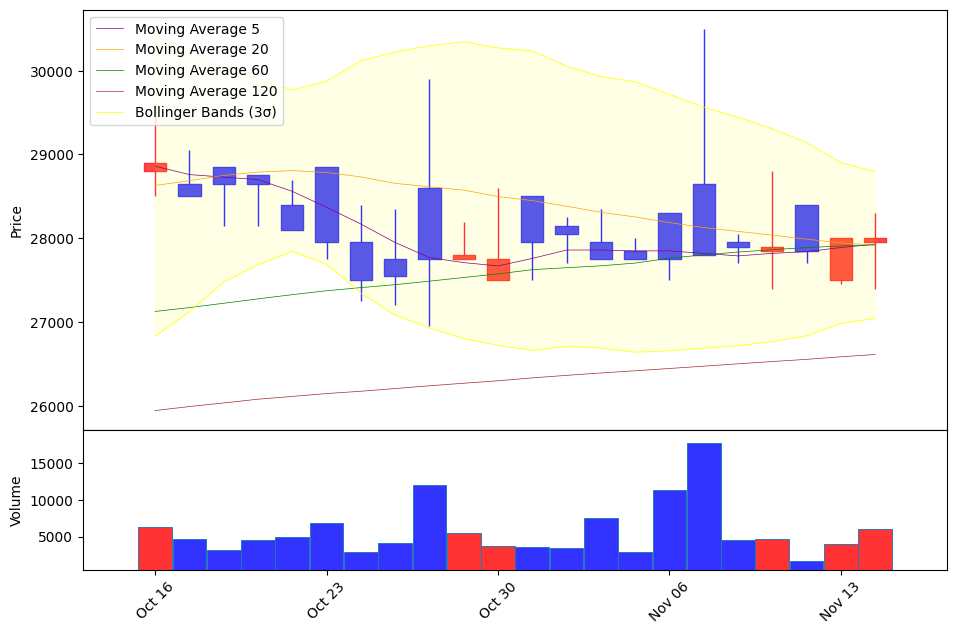

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


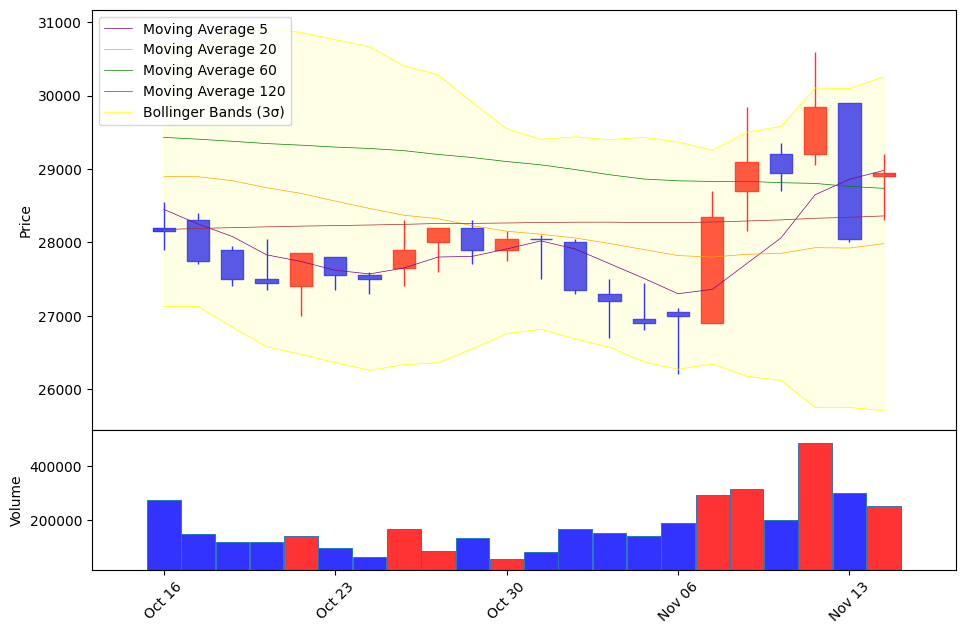

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


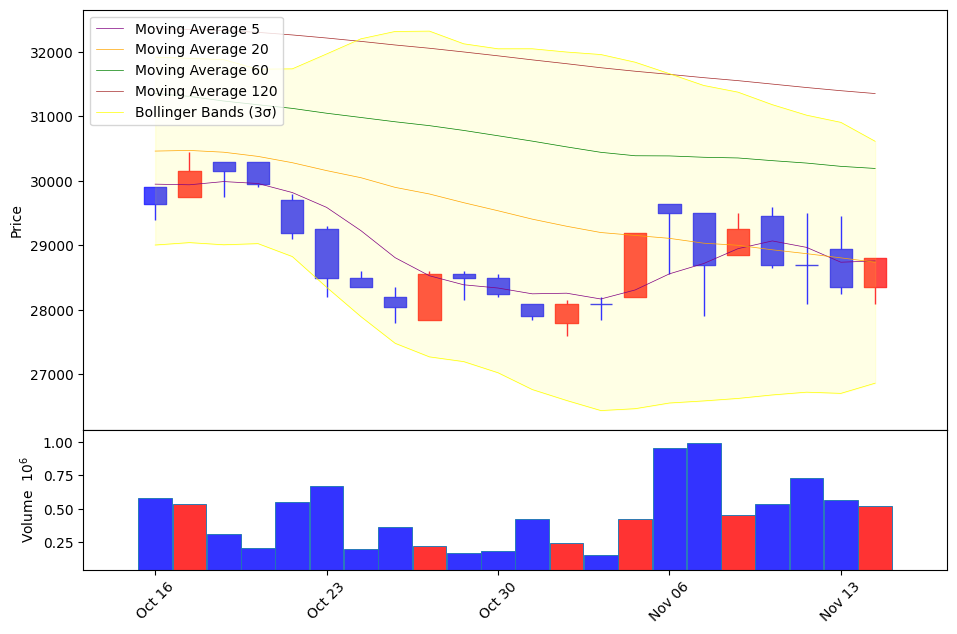

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


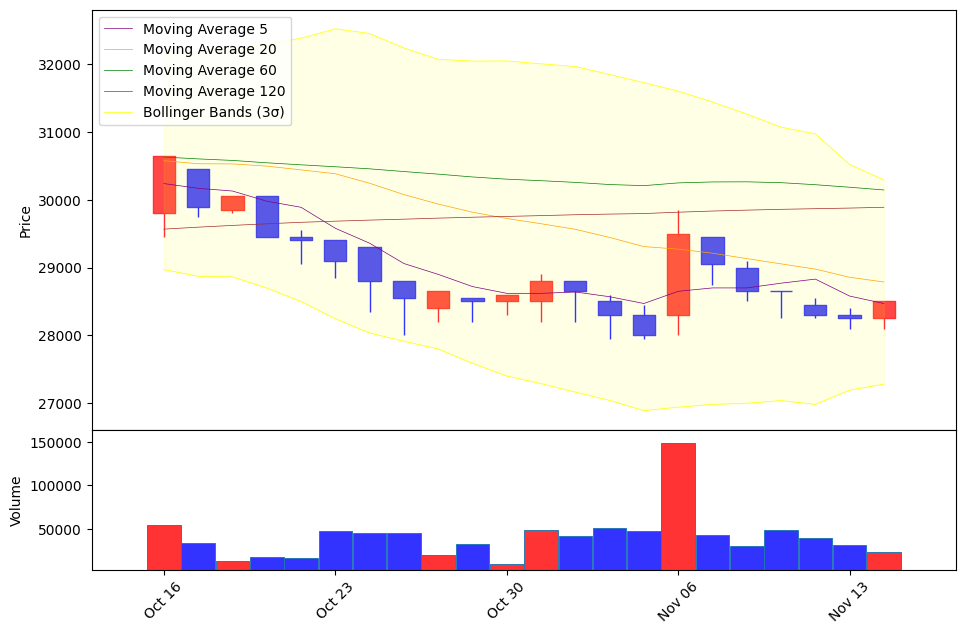

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


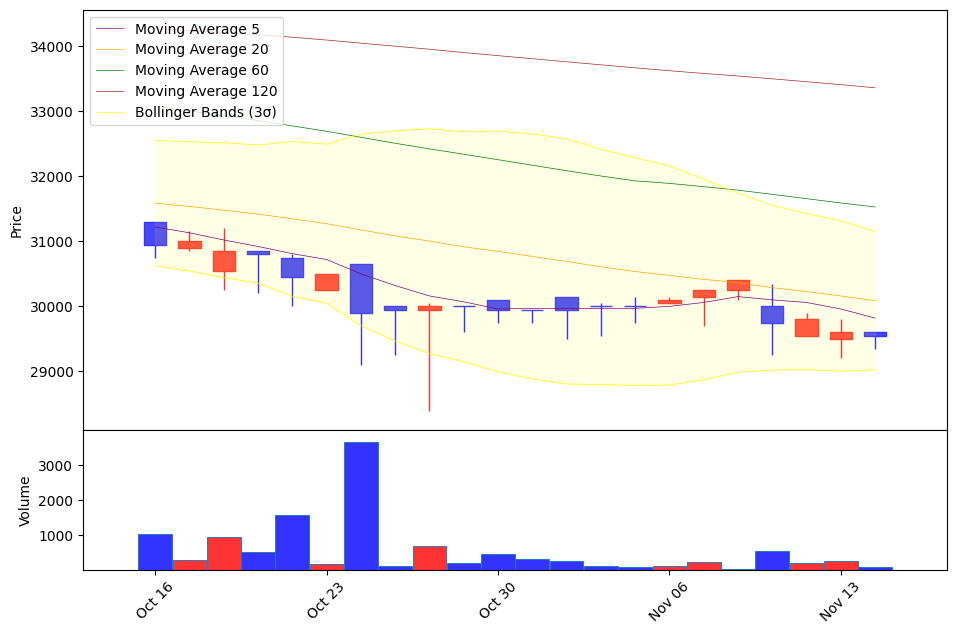

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


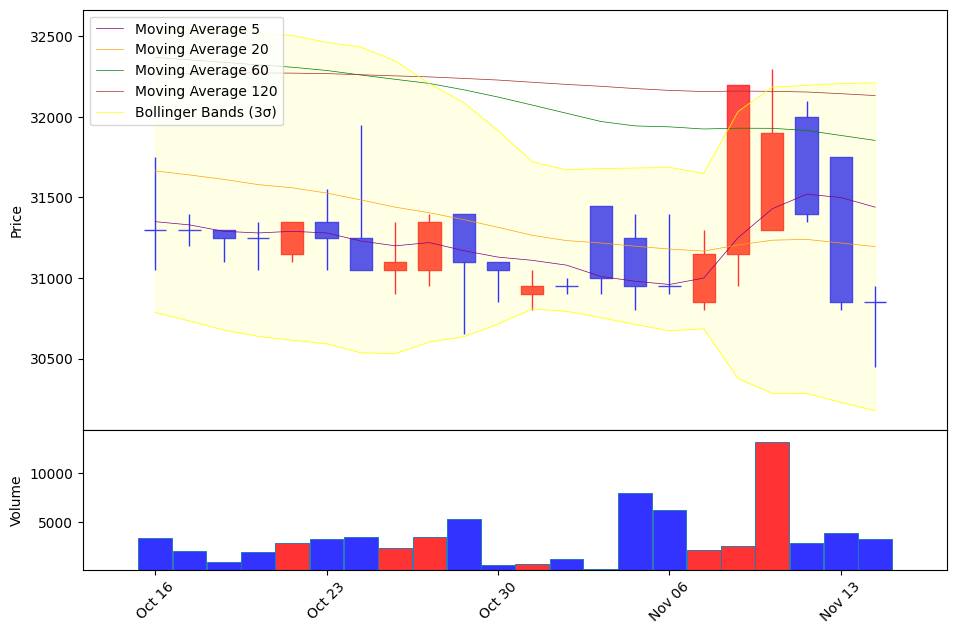

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


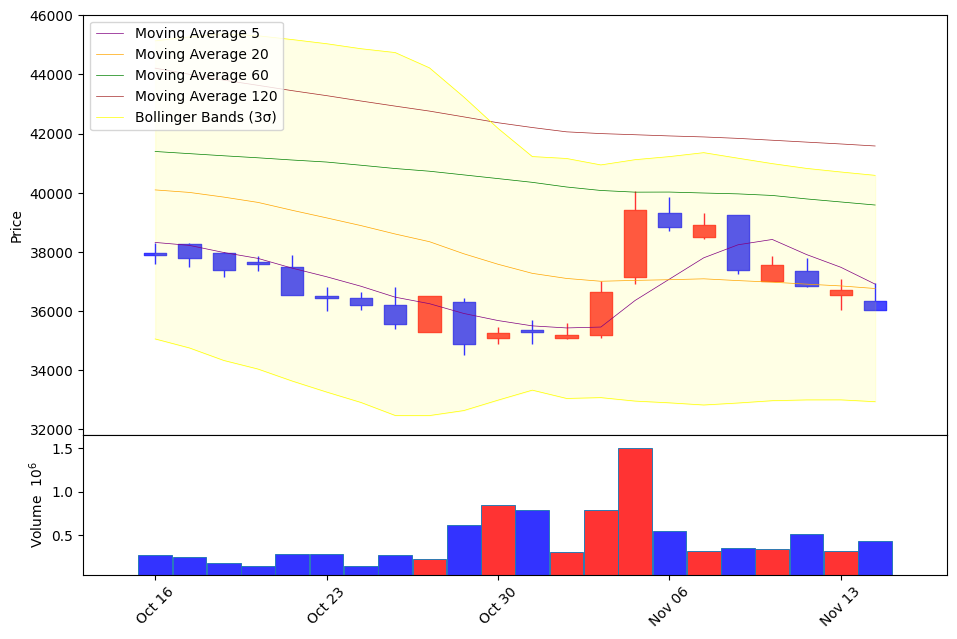

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


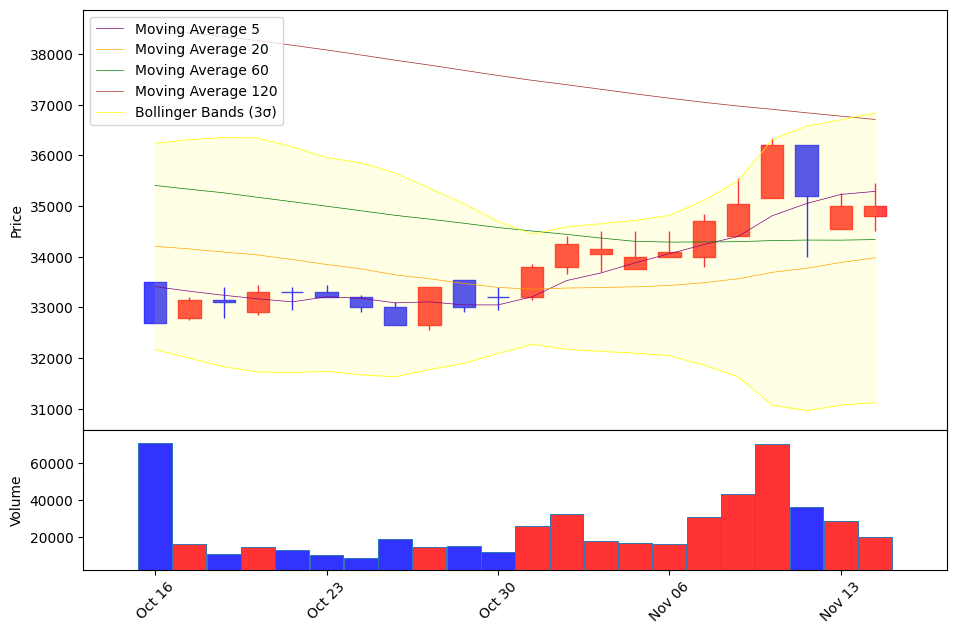

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


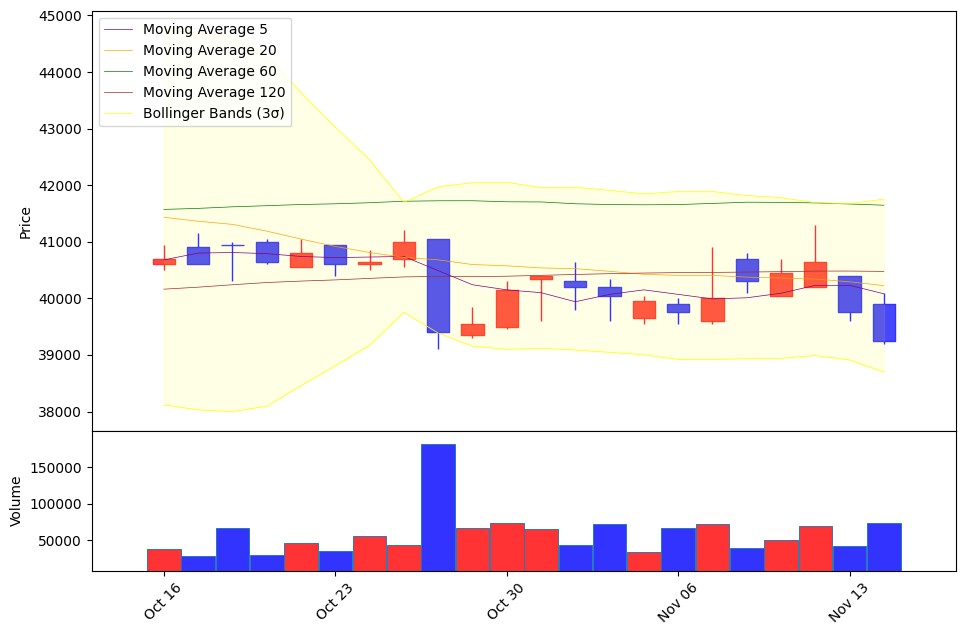

<ipython-input-7-eec812c37a76>:44: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_month = df.last('30D')


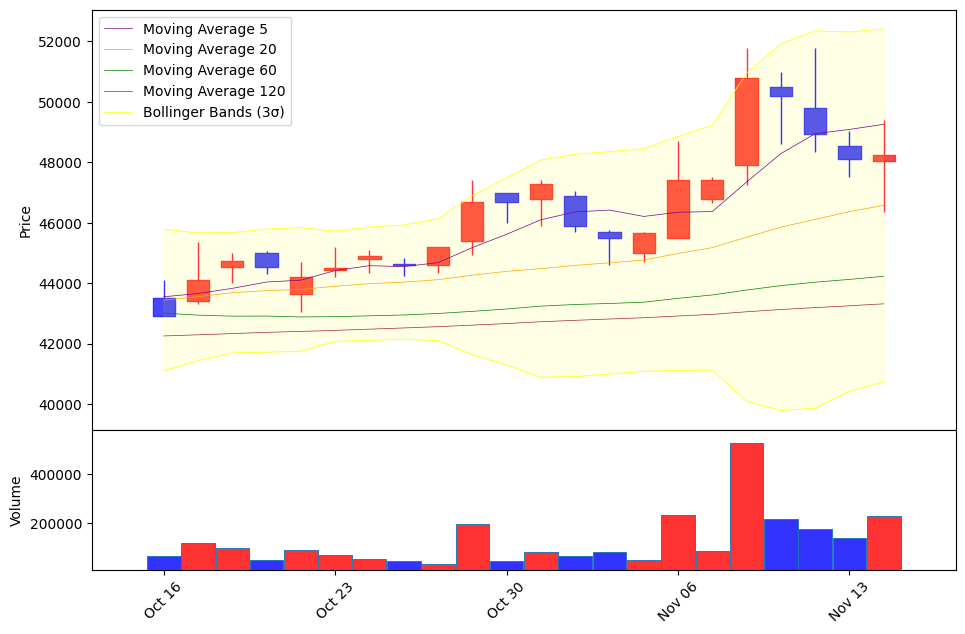

In [ ]:
import FinanceDataReader as fdr
import pandas as pd
import mplfinance as mpf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import json
import os

# JSON file path
file_path = '/content/drive/MyDrive/filtered_stock_predictions.json'
save_dir = '/content/drive/MyDrive/stock_charts'

# Create save directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

# Load JSON file
with open(file_path, 'r', encoding='utf-8') as f:
    stock_data = json.load(f)

# Set date range (1 year from today)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Function to plot stock chart
def plot_stock_chart(symbol, company_name, graph_num):
    # Fetch stock data
    df = fdr.DataReader(symbol, start_date, end_date)

    # Calculate moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA60'] = df['Close'].rolling(window=60).mean()
    df['MA120'] = df['Close'].rolling(window=120).mean()

    # Calculate Bollinger Bands (20-day, 3 standard deviations)
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + 3 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 3 * df['BB_std']

    # Select last month of data
    last_month = df.last('30D')

    # Set candlestick chart style
    mc = mpf.make_marketcolors(up='#ff3333', down='#3333ff', inherit=True)
    s = mpf.make_mpf_style(marketcolors=mc)

    # Define colors for moving averages and Bollinger Bands
    line_colors = {
        'MA5': 'purple', 'MA20': 'orange', 'MA60': 'green', 'MA120': 'brown',
        'BB_upper': 'yellow', 'BB_lower': 'yellow'
    }

    # Set up additional plots for moving averages and Bollinger Bands
    add_plots = [
        mpf.make_addplot(last_month[ma], color=color, width=0.5)
        for ma, color in line_colors.items() if ma.startswith('MA')
    ] + [
        mpf.make_addplot(last_month['BB_upper'], color='yellow', width=0.5),
        mpf.make_addplot(last_month['BB_lower'], color='yellow', width=0.5)
    ]

    # Set fill area between Bollinger Bands
    fill_between = dict(y1=last_month['BB_lower'].values, y2=last_month['BB_upper'].values, color='yellow', alpha=0.1)

    # Plot candlestick chart
    fig, axes = mpf.plot(last_month, type='candle', style=s,
                         addplot=add_plots, volume=True, figsize=(12, 8),
                         returnfig=True, panel_ratios=(3,1), fill_between=fill_between)

    # Manually create legend
    legend_elements = [
        Line2D([0], [0], color=color, lw=0.5, label=ma.replace('MA', 'Moving Average '))
        for ma, color in line_colors.items() if ma.startswith('MA')
    ] + [Line2D([0], [0], color='yellow', lw=0.5, label='Bollinger Bands (3σ)')]

    # Add legend
    axes[0].legend(handles=legend_elements, loc='upper left')

    # Save the chart to file
    save_path = os.path.join(save_dir, f'graph{graph_num}.png')
    plt.savefig(save_path, format='png', dpi=300)

    # Display the chart
    plt.show()

# Plot and save charts for the top 10 stocks
for i, stock in enumerate(stock_data[:10]):
    symbol = stock["symbol"]
    company_name = stock["company_name"]
    plot_stock_chart(symbol, company_name, i + 1)


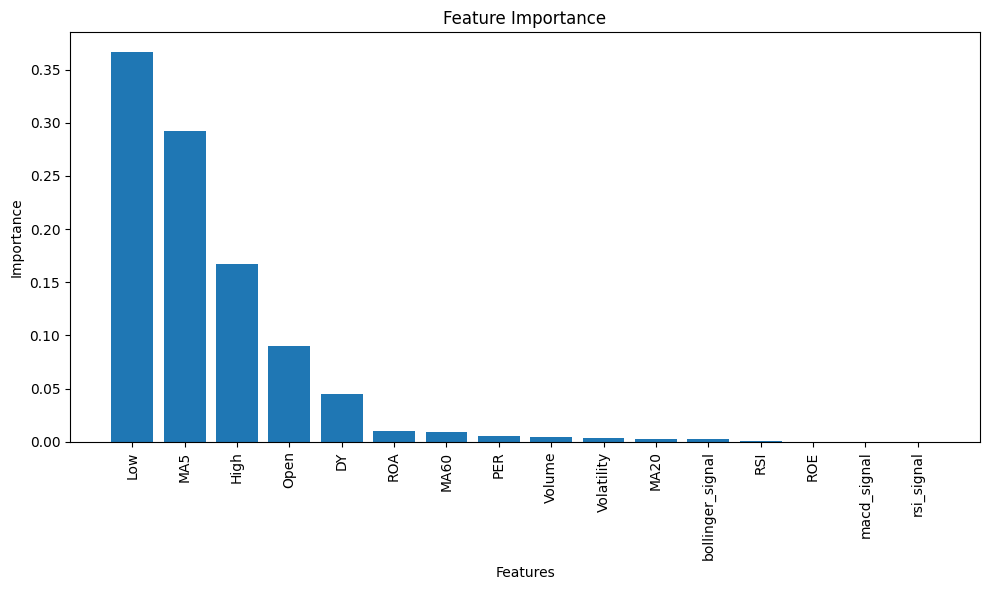

Top 10 Most Important Features:
       feature  importance
2          Low    0.366755
4          MA5    0.292027
1         High    0.167560
0         Open    0.090162
12          DY    0.044871
10         ROA    0.009998
6         MA60    0.009412
9          PER    0.005025
3       Volume    0.004364
7   Volatility    0.003745


In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# 모델 로드
model = joblib.load('/content/drive/MyDrive/stock_models/model_10d.joblib')

# 특성 중요도 추출
feature_importance = model.named_estimators_['xgb'].feature_importances_

# 특성 이름 가져오기 (모델 학습 시 사용한 특성 순서와 동일해야 함)
feature_names = ['Open', 'High', 'Low', 'Volume', 'MA5', 'MA20', 'MA60', 'Volatility', 'RSI',
                 'PER', 'ROA', 'ROE', 'DY', 'macd_signal', 'bollinger_signal', 'rsi_signal']

# 특성 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 상위 10개 특성 출력
print("Top 10 Most Important Features:")
print(importance_df.head(10))

그래프 코드 설명


---
최종적으로 추출한 상위 10개 종목의 그래프.

30일간의 캔들차트이며, 20일 이동평균과 3시그마를 사용한 볼린저 밴드, 5, 20, 60, 120일 이동평균을 추가함.

생성된 그래프는 '/content/drive/MyDrive/stock_charts'에 graph(n).png로 저장.